# Supervised learning
Now that we loaded and explored the data, let's start with building our first models.
In this chapter, we'll only look at a very simple model, the k-Nearest Neighbors classifier.
It's easy to understand and has all the ingredients you need to know for a machine learning workflow.
In chapter TODO, we'll discuss many other models.

```{margin}
The interface of all the models is the same in scikit-learn,
so you can easily switch out the code for another model now if you like.
```

## Classification with scikit-learn
We will start with the simple and well-behaved breast cancer dataset:

In [3]:
from sklearn.datasets import load_breast_cancer
# specifying "as_frame=True" returns the data as a dataframe in addition to a numpy array
cancer = load_breast_cancer(as_frame=True)
cancer_df = cancer.frame
cancer_df.shape

(569, 31)

In [4]:
cancer_df.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'target'],
      dtype='object')

### Training and Test set

First, we split our data into a training and a test set. TODO is this the first mention?
This is a critical component of any supervised learning workflow. As you know, our goal is to build a model that generalizes well, i.e. that predicts well on data that is has not seen before.
We could use all our data to built a model, but then we would have no way to know whether our model really works, i.e. how accurately it predicts on new data.
The easiest way to measure the generalization capability of our model is to apply it to some hold-out data, that was not used to build the model, but for which we have the correct answer.
Then we can make predictions on our hold-out set and compare them against the known answers, to measure how well the model performs.
So we need disjoint datasets: one to build the model, usually called the training set, and another, to validate model accuracy, usually called the test set.

![:scale 60%](images/train_test_set_2d_classification.png)


A very common way to generate the test set is to split the data randomly, and there's function in scikit-learn to help you with that, called ``train_test_split``:

In [6]:
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(cancer_df)

This function splits off 25% of the rows randomly to use as test set:

In [10]:
data_train.shape

(426, 31)

In [11]:
data_test.shape

(143, 31)

We can controll the size of the test set by changing the ``test_size`` parameter to either a number of samples or a percentage of the training data. But 75% of the data is usually a good rule of thumb. As the process is random, you will get a different split of the data every time you run this line of code. For the purposes of this book, we'll make the split deterministic by providing a fixed random seed, which can be an arbitrary integer:

In [7]:
data_train, data_test = train_test_split(cancer_df, random_state=42)

This way, the results of our analysis later will be the same every time as when you run the code, and the won't change if you run the code again.

```{margin} Setting random seeds
In a real analysis, there are pros and cons to setting this seed. Generally, your results should be independent of how you split your data. If the quality of your model depends strongly of how you split your data, then your model is probably not very robust and you might not want to use it. If you keep the seed fixed the whole time, you might not know whether you got lucky (or unlucky) with your particular split, so it might be good to either not set the seed, or run with multiple different seeds. On the other hand, if you didn't set the seed, and you get a surprising result, then it might be very hard for someone else (or even for yourself) to reproduce your results as you have no record of how the data was split.
```

There are actually quite some assumptions made when splitting the data randomly, and we will discuss them in more detail in chapter TODO.

Now, we separate the features from the target, which is required for using scikit-learn.
The easiest way to do that is to use the ``drop`` method of the DataFrame:

In [12]:
X_train = data_train.drop(columns='target')
y_train = data_train.target
X_test = data_test.drop(columns='target')
y_test = data_test.target

Here, we're calling the features 'X' and the targets 'y', a common convention in scikit-learn and machine learning more broadly.
```{margin}
The 'X' is capital because it refers to a matrix, a two-dimensional array, while 'y' is typically a column vector or one-dimensional array. Using capital letters for matrices and lower case letters for vectors is a common practice in linear algebra.
```

````{Note}
Alternatively, we could have first split off the target column and then separated the data into training and test set, like so:
    ```{python}
    X = data.drop(columns='target')
    y = data.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    ```
This is one line shorter and the more common idiom, but maybe a bit harder to read and remember.
````  

Now we're all set and can get started building our first models with scikit-learn!

## Nearest Neighbors Classification


The first algorithm we'll use is Nearest Neighbors classification. It's not commonly used in practice as it doesn't scale that well to datasets with many samples, but it's often quite accurate and very easy to understand.
For illustration purposes (as it is easier to draw in two dimensions), let us first consider just two features of the breast cancer dataset that we found informative before, 'mean compactness' and 'worst concave points':

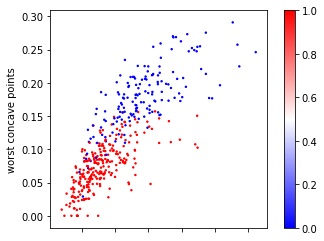

In [43]:
import matplotlib.pyplot as plt
# the return value is the axes that was created for the plot
ax = X_train.plot.scatter(x='mean compactness', y='worst concave points',
                     # use the target to color points
                     # use the blue-white-red colormap
                     c=y_train, colormap='bwr', s=2)
# TODO why is there no xlabel
# We set the aspect ratio to equal to faithfully represent distances between points.
ax.set_aspect("equal")

Now let's look at some of the samples from the test set, drawn as black stars:

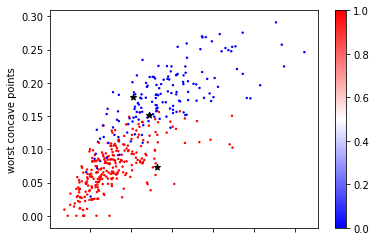

In [48]:
ax = X_train.plot.scatter(x='mean compactness', y='worst concave points',
                         c=y_train, colormap='bwr', s=2)
# plot into the axme axes
X_test[1:4].plot.scatter(x='mean compactness', y='worst concave points', c='k', marker="*", s=40, ax=ax);

Looking at this two dimensional scatter plot, we can probably make a reasonable guess that the most likely label for the top one is blue, as all the surrounding points are blue, while the most likely label for the bottom point is red, because all the surrounding points are read. It's maybe a little bit less clear what label to assign to the point in the center.

Nearest Neighbors, as the name suggest, formalizes this intuition and simply applies the label of the closest point in the training dataset, as illustrated in Figure TODO.




In [49]:
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import KNeighborsClassifier

def plot_n_neighbors(X_train, y_train, X_test, n_neighbors=1):
    dist = euclidean_distances(X, X_test)
    closest = np.argsort(dist, axis=0)

    plt.figure()
    plt.gca().set_aspect("equal")
    for x, neighbors in zip(X_test, closest.T):
        for neighbor in neighbors[:n_neighbors]:
            plt.arrow(x[0], x[1], X[neighbor, 0] - x[0],
                    X[neighbor, 1] - x[1], head_width=0, fc='k', ec='k')

    clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X, y)
    test_points = plt.scatter(X_test[:, 0], X_test[:, 1], c=clf.predict(X_test), marker="*")
    training_points = plt.scatter(X[:, 0], X[:, 1], c=y)    
    
plot_n_neighbors(X_train[['mean compactness', 'worst concave points']], y_train, X_test[1:4])

ModuleNotFoundError: No module named 'sklearn.decomposition.dict_learning'


```{admonition} Mathematical Background
Formally, you could define the prediction of nearest neighbors based on a dataset $(x_i, y_i), i=1,..,n$ as:
$$f(x) = y_i, i = \text{argmin}_j || x_j - x||$$
```

Let’s say we have this two-class classification dataset here, with
two features, one on the x axis and one on the y axis.
And we have three new points as marked by the stars here.
If I make a prediction using a one nearest neighbor classifier, what
will it predict?
It will predict the label of the closest data point in the training set.
That is basically the simplest machine learning algorithm I can come
up with.

Here’s the formula:
the prediction for a new x is the y_i so that x_i is the closest point
in the training set.
Ok, so now how do we find out whether this model is any good?



The simplest way is to split the data into a training and a test set.
So we take some part of the data set,  let’s say 75% and the
corresponding output, and train the model, and then apply the model on
the remaining 25% to compute the accuracy. This test-set accuracy
will provide an unbiased estimate of future performance.
So if our i.i.d. assumption is correct, and we get a 90% success
rate on the test data, we expect about a 90% success rate on any future
data, for which we don't have labels.

Let's dive into how to build and evaluate this model with scikit-learn.

## KNN with scikit-learn

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print("accuracy: ", knn.score(X_test, y_test))
y_pred = knn.predict(X_test)

accuracy:  0.6153846153846154



We import train_test_split form model selection, which does a
random split into 75%/25%.
We provide it with the data X, which are our two features, and the
labels y.

As you might already know, all the models in scikit-learn are implemented
in python classes, with a single object used to build and store the model.

We start by importing our model, the KneighborsClassifier, and instantiate
it with n_neighbors=1. Instantiating the object is when we set any hyper parameter,
such as here saying that we only want to look at the neirest neighbor.

Then we can call the fit method to build the model, here knn.fit(X_train,
y_train)
All models in scikit-learn have a fit-method, and all the supervised ones take
the data X and the outcomes y. The fit method builds the model and stores any
estimated quantities in the model object, here knn.  In the case of nearest
neighbors, the `fit` methods simply remembers the whole training set.

Then, we can use knn.score to make predictions on the test data, and
compare them against the true labels y_test.

For classification models, the score method will always compute
accuracy.

Just for illustration purposes, I also call the predict method here.
The predict method is what's used to make predictions on any dataset.
If we use the score method, it calls predict internally and then
compares the outcome to the ground truth that's provided.

Who here has not seen this before?

## Influence of Number of Neighbors


So this was the predictions as made by one-nearest neighbor.
But we can also consider more neighbors, for example three. Here is the
three nearest neighbors for each of the points and the corresponding
labels.
We can then make a prediction by considering the majority among these
three neighbors.
And as you can see, in this case all the points changed their labels! (I
was actually quite surprised when I saw that, I just picked some points
at random).
Clearly the number of neighbors that we consider matters a lot. But what
is the right number?
The is a problem you’ll encounter a lot in machine learning, the
problem of tuning parameters of the model, also called hyper-parameters,
which can not be learned directly from the data.


So this was the predictions as made by one-nearest neighbor.
But we can also consider more neighbors, for example three. Here is the
three nearest neighbors for each of the points and the corresponding
labels.
We can then make a prediction by considering the majority among these
three neighbors.
And as you can see, in this case all the points changed their labels! (I
was actually quite surprised when I saw that, I just picked some points
at random).
Clearly the number of neighbors that we consider matters a lot. But what
is the right number?
The is a problem you’ll encounter a lot in machine learning, the
problem of tuning parameters of the model, also called hyper-parameters,
which can not be learned directly from the data.

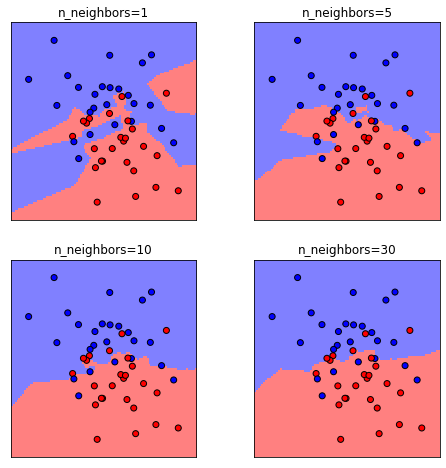

In [3]:
import sys
sys.path.append("..")
from utils import plot_2d_classification
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for ax, n_neighbors in zip(axes.ravel(), [1, 5, 10, 30]):
    ax.set_title(f"n_neighbors={n_neighbors}")
    clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X, y)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k')
    plot_2d_classification(clf, X, ax=ax, alpha=.5)
    ax.set_aspect("equal")


Here’s an overview of how the classification changes if we consider
different numbers of neighbors.
You can see as red and blue circles the training data. And the background
is colored according to which class a datapoint would be assigned to
for each location.
For one neighbor, you can see that each point in the training set has
a little area around it that would be classified according to it’s
label. This means all the training points would be classified correctly,
but it leads to a very complex shape of the decision boundary.
If we increase the number of neighbors, the boundary between red and
blue simplifies, and with 40 neighbors we mostly end up with a line.
This also means that now many of the training data points would be
labeled incorrectly.

## Model complexity

![:scale 75%](images/knn_model_complexity.png)


We can look at this in more detail by comparing training and test set
scores for the different numbers of neighbors.
Here, I did a random 75%/25% split again. This is a very noisy plot as
the dataset is very small and I only did a random split, but you can
see a trend here.
You can see that for a single neighbor, the training score is 1 so perfect
accuracy, but the test score is only 70%.  If we increase the number of
neighbors we consider, the training score goes down, but the test score
goes up, with an optimum at 19 and 21, but then both go down again.

This is a very typical behavior, that I sketched in a schematic for you.


here is a cartoon version of how this chart looks in general, though
it's horizontally flipped to the one with saw for knn.
This chart has accuracy on the y axis, and the abstract concept of model
complexity on the x axis.
If we make our machine learning models more complex, we will get better
training set accuracy, as the model will be able to capture more of the
variations in the data.


But if we look at the generalization performance, we get a different
story. If the model complexity is too low, the model will not be able
to capture the main trends, and a more complex model means better
generalization.
However, if we make the model too complex, generalization performance
drops again, because we basically learn to memorize the dataset.



## Overfitting and Underfitting

![:scale 80%](images/overfitting_underfitting_cartoon_full.png)


If we use too simple a model, this is often called underfitting, while
if we use to complex a model, this is called overfitting. And somewhere
in the middle is a sweet spot.
Most models have some way to tune model complexity, and we’ll see many
of them in the next couple of weeks.
So going back to nearest neighbors, what parameters correspond to high
model complexity and what to low model complexity? high n_neighbors =
low complexity!

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
sklearn.set_config(print_changed_only=True)

In [5]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
blood = fetch_openml('blood-transfusion-service-center')

X_train, X_test, y_train, y_test = train_test_split(
    blood.data, blood.target, random_state=0)

In [6]:
X_train.shape

(561, 4)

In [7]:
import pandas as pd
pd.Series(y_train).value_counts()

1    438
2    123
dtype: int64

In [8]:
pd.Series(y_train).value_counts(normalize=True)

1    0.780749
2    0.219251
dtype: float64